In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

# Data

In [2]:
PATH = 'data/toxic/'
! ls {PATH}

sample_submission.csv  test.csv  test_labels.csv  train.csv


In [3]:
train = pd.read_csv(PATH + 'train.csv')

val_idxs = get_cv_idxs(len(train))
val = train.iloc[val_idxs]
train = train.drop(val_idxs, axis=0)

test = pd.read_csv(PATH + 'test.csv')

In [4]:
train.iloc[np.random.choice(np.arange(len(train)), size=3)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
106142,37d5915f04a5d0cd,""" \nEditors sometimes make the mistake of thin...",0,0,0,0,0,0
101687,202bf308afc61d34,"""\n\nMain Page \n\nBy the way, if noone else t...",0,0,0,0,0,0
145518,1de9870bbe81b7a4,I posted several links to photos and substanti...,0,0,0,0,0,0


In [5]:
test.head(3)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."


In [6]:
# python -m spacy download en
spacy_tok = spacy.load('en')

In [7]:
TEXT = data.Field(lower=True, tokenize='spacy')

fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passing it our torchtext field object, and the paths to our training, test, and validation sets. In this case, we don't have a separate test set, so we'll just use `VAL_PATH` for that too.

As well as the usual `bs` (batch size) parameter, we also not have `bptt`; this define how many words are processing at a time in each row of the mini-batch. More importantly, it defines how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.

In [8]:
bs=32; bptt=40

In [9]:
md = LanguageModelData.from_dataframes(PATH, field=TEXT, col='comment_text',
                                       train_df=train, val_df=val, test_df=test,
                                       bs=bs, bptt=bptt, min_freq=10)

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [11]:
# python's standard Pickle library can't handle this correctly,
# so at the top of this notebook we used the dill library instead and imported it as pickle.
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [12]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '.', 'the', ',', '"', 'to', 'i', 'of', 'and', 'you', 'a']

In [13]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['the']

3

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [14]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(8653, 23815, 1, 11078229)

Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [15]:
md.trn_ds[0].text[:12]

["d'aww",
 '!',
 'he',
 'matches',
 'this',
 'background',
 'colour',
 'i',
 "'m",
 'seemingly',
 'stuck',
 'with']

In [16]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
    0
   24
   67
 2601
   22
  730
 3844
    7
   97
 4582
 2633
   39
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [17]:
next(iter(md.trn_dl))

(Variable containing:
      0     46    231  ...     665    294      2
     24      4    301  ...     976    140    578
     67     17      6  ...       4    131     15
         ...            ⋱           ...         
    158     29     13  ...       0     19   1372
     23   4687     10  ...     166      5     17
    273      9     32  ...       3     15      2
 [torch.cuda.LongTensor of size 39x32 (GPU 0)], Variable containing:
     24
      4
    301
   ⋮   
    783
     16
     27
 [torch.cuda.LongTensor of size 1248 (GPU 0)])

# Embeddings

## Setup 

In [20]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.

In [21]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [22]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                       dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [23]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(23815, 200, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(23815, 200, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=200, out_features=23815, bias=False)
    (dropout): LockedDropout(
    )
  )
)

## Train 

 83%|████████▎ | 7143/8653 [04:33<00:57, 26.10it/s, loss=18.7]

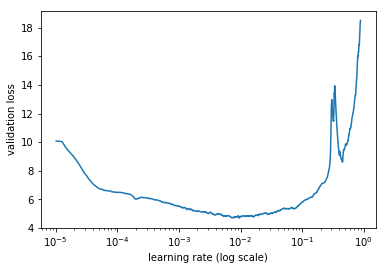

In [24]:
learner.lr_find()
learner.sched.plot()

In [25]:
learner.fit(3e-3, 4, wds=5e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                
    0      4.446779   4.47741   
    1      4.278362   4.328239                                
    2      4.282017   4.232808                                
    3      4.244484   4.295422                                
    4      4.102998   4.220167                                
    5      4.088969   4.160686                                
    6      4.11427    4.130597                                
    7      4.174942   4.254909                                
    8      4.125337   4.231668                                
    9      4.11561    4.201776                                
    10     4.083267   4.163179                                
    11     4.098549   4.134981                                
    12     4.112281   4.102182                                
    13     3.991575   4.077729                                
    14     4.007923   4.070069                                


[array([4.07007])]

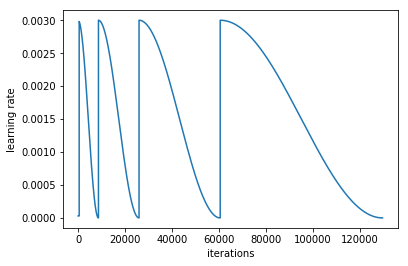

In [29]:
learner.sched.plot_lr()

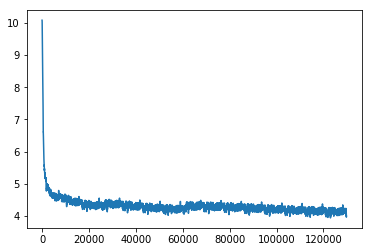

In [30]:
learner.sched.plot_loss()

In [52]:
learner.save('m1')
learner.save_encoder('adam1_enc')

In [53]:
learner.load_encoder('adam1_enc')

### Again...

 90%|█████████ | 7829/8653 [05:01<00:31, 25.94it/s, loss=15.2]

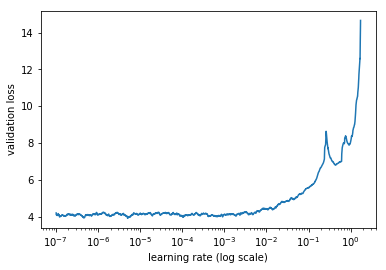

In [75]:
learner.lr_find(start_lr=1e-7)
learner.sched.plot()

In [ ]:
learner.fit(3e-3, 4, wds=5e-6, cycle_len=1, cycle_mult=2)

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [52]:
learner.save('m2')
learner.save_encoder('adam2_enc')

In [53]:
learner.load_encoder('adam2_enc')

## Test 

In [62]:
m = learner.model

In [69]:
ss="""point made no sense - why not argue to include"""
s = [TEXT.tokenize(ss)]  # s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'point made no sense - why not argue to include'

In [70]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [71]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['the', 'a', 'it', 'that', 'this', '<unk>', 'an', 'them', 'all', 'any']

In [72]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

point made no sense - why not argue to include 

the " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " template " " ...
